In [7]:
import pandas as pd
import os

def load_email_data():
    """Load all categorized email Excel files"""
    categories = ['business', 'education', 'personal', 'promotions']
    data_frames = []
    
    for category in categories:
        file_path = f'Downloads/{category}_emails.xlsx'
        if os.path.exists(file_path):
            df = pd.read_excel(file_path)
            
            # Find text content column (case-insensitive)
            text_columns = [col for col in df.columns 
                          if 'text' in col.lower() or 'body' in col.lower()]
            
            if text_columns:
                df = df.rename(columns={text_columns[0]: 'text'})
                df['category'] = category
                data_frames.append(df[['text', 'category']])
            else:
                print(f"⚠️ No text column found in {file_path}")
    
    if not data_frames:
        raise ValueError("No valid data files found in Downloads folder")
    
    return pd.concat(data_frames, ignore_index=True)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

def prepare_training_data(df):
    """Prepare text data for machine learning"""
    # Clean and vectorize text
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words='english',
        ngram_range=(1, 2)  # Include bigrams
    )
    
    X = vectorizer.fit_transform(df['text'].fillna(''))
    y = df['category']
    
    # Split data (80% train, 20% test)
    return train_test_split(X, y, test_size=0.2, random_state=42), vectorizer

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def train_classification_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple classifiers"""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'SVM': SVC(kernel='linear', probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=150)
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        results[name] = {
            'model': model,
            'predictions': y_pred
        }
    
    return results

In [11]:
from sklearn.metrics import (accuracy_score, precision_score, 
                           recall_score, f1_score, confusion_matrix)

def calculate_metrics(y_true, y_pred, classes):
    """Calculate and return all evaluation metrics"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average=None, labels=classes),
        'recall': recall_score(y_true, y_pred, average=None, labels=classes),
        'f1': f1_score(y_true, y_pred, average=None, labels=classes),
        'confusion_matrix': confusion_matrix(y_true, y_pred, labels=classes)
    }

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results, y_test, class_names):
    """Generate all visualizations"""
    # 1. Accuracy Comparison
    plt.figure(figsize=(10, 6))
    accuracies = {name: accuracy_score(y_test, res['predictions']) 
                for name, res in results.items()}
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()
    
    # 2. Confusion Matrix for Best Model
    best_model_name = max(accuracies, key=accuracies.get)
    cm = results[best_model_name]['confusion_matrix']
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # 3. Precision-Recall-F1 Comparison
    metrics = []
    for name, res in results.items():
        for i, class_name in enumerate(class_names):
            metrics.append({
                'Model': name,
                'Class': class_name,
                'Precision': res['precision'][i],
                'Recall': res['recall'][i],
                'F1': res['f1'][i]
            })
    
    metric_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(['Precision', 'Recall', 'F1']):
        sns.barplot(x='Class', y=metric, hue='Model', data=metric_df, ax=axes[i])
        axes[i].set_title(metric)
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

📧 Email Classification Analysis
-------------------------------
⚠️ No text column found in Downloads/promotions_emails.xlsx

📊 Loaded email categories:
business     24
education    23
personal      3
Name: category, dtype: int64

Training Logistic Regression...

Training Naive Bayes...

Training SVM...

Training Random Forest...


c:\Users\aspk1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


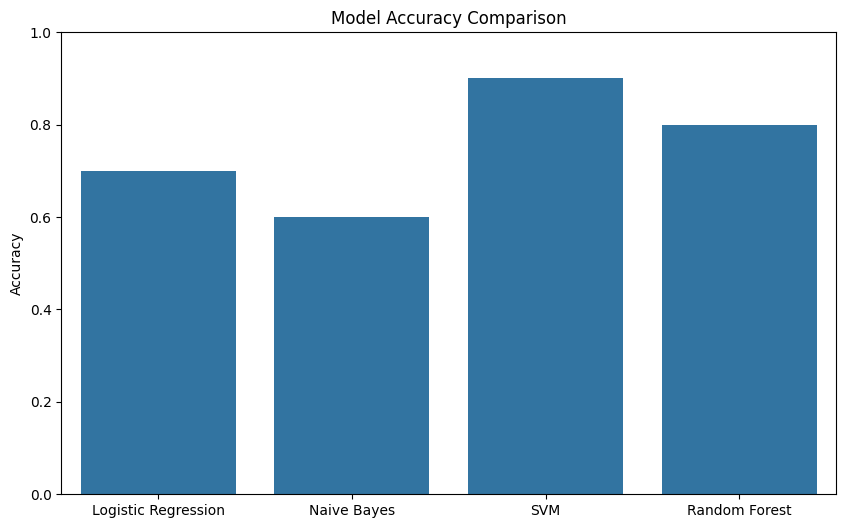

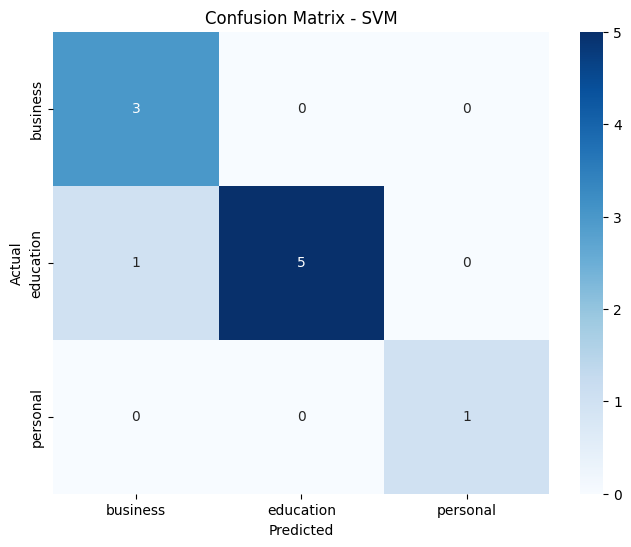

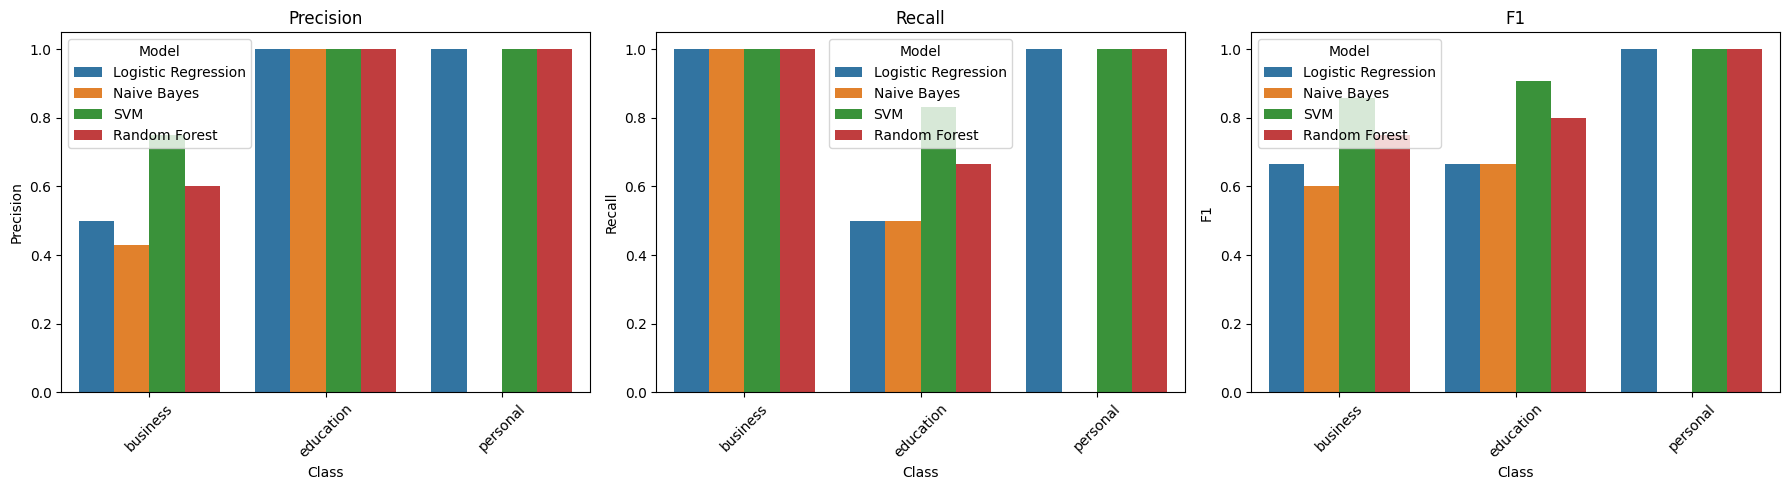


💾 Saved best model (SVM) to disk


In [13]:
import joblib


def main():
    print("📧 Email Classification Analysis")
    print("-------------------------------")
    
    try:
        # 1. Load data
        email_df = load_email_data()
        print("\n📊 Loaded email categories:")
        print(email_df['category'].value_counts())
        
        # 2. Prepare data
        (X_train, X_test, y_train, y_test), vectorizer = prepare_training_data(email_df)
        
        # 3. Train models
        models = train_classification_models(X_train, X_test, y_train, y_test)
        
        # 4. Calculate metrics
        class_names = sorted(email_df['category'].unique())
        for name in models:
            models[name].update(
                calculate_metrics(y_test, models[name]['predictions'], class_names)
            )
        # 5. Visualize results
        visualize_results(models, y_test, class_names)
        
        # 6. Save best model
        best_model = max(models.items(), 
                        key=lambda x: x[1]['accuracy'])
        joblib.dump(best_model[1]['model'], 'best_model.pkl')
        joblib.dump(vectorizer, 'vectorizer.pkl')
        print(f"\n💾 Saved best model ({best_model[0]}) to disk")
        
    except Exception as e:
        print(f"\n❌ Error: {str(e)}")

if __name__ == '__main__':
    main()